In [1]:
import re

import pandas as pd
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats

sns.set_style("whitegrid")

In [2]:
crime = pd.read_csv('/Users/guest/Dropbox/Education/Thinkful/Unit 2/L4 - Linear Regression/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv',
                    header=4,
                    skipfooter = 3,
                    engine='python',
                    warn_bad_lines = True,
                    skip_blank_lines = True,
                   encoding="utf-8")

### Cleaning the data

In [3]:
# Tidy up the column names
crime.columns = crime.columns.str.strip().str.lower()

replacement_definitions = {' ':'_', 
                           '(':'',
                           ')':'',
                           '\n':'_',
                           '3':'',
                           '-':''}
for definition in replacement_definitions:
    crime.columns = crime.columns.str.replace(definition,replacement_definitions[definition])
    
# Set crime as the index
crime = crime.set_index('city')
    
# Replace nans with 0s
crime = crime.fillna(value=0)

# Convert all values to floats
for col in crime.columns:
    try:
        crime[col] = crime[col].apply(lambda x: float(x.replace(',', '')))
    except:
        crime[col] = crime[col].apply(lambda x: float(x))

In [4]:
# Rape – revised definition is empty. Get rid of it!
crime['rape'] = crime['rape_legacy_definition2']
crime = crime.drop(['rape_revised_definition1', 'rape_legacy_definition2'], axis='columns')

In [5]:
crime.describe()

,population,violent_crime,murder_and_nonnegligent_manslaughter,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,rape
count,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,4.003763e+04,201.594828,1.566092,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.005747,5.864943
std,4.500374e+05,2815.268504,18.303673,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,7.884612,60.425452
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,0.000000,2.000000
max,8.396126e+06,52384.000000,335.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000,1112.000000


__Everything has ridiculously high variance – I'm going to look for outliers.__

In [6]:
def describe_outliers(frame):
    for variable in list(frame):
        var_mean = frame[variable].mean()
        var_std = frame[variable].std()

        lower = var_mean - var_std * 2
        upper = var_mean + var_std * 2

        low_outliers = frame.loc[(frame[variable] < lower)][[variable]]
        high_outliers = frame.loc[(frame[variable] > upper)][[variable]]

        print('\n{} outliers:'.format(variable))
        if not low_outliers.empty:
            print(low_outliers)
        if not high_outliers.empty:
            print(high_outliers)

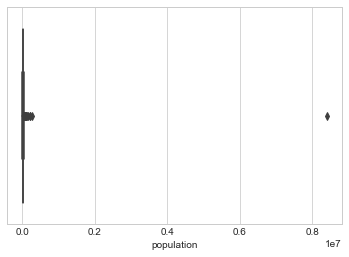

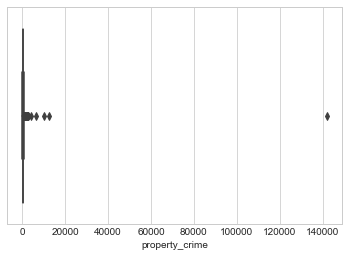

In [7]:
continuous_variables = ['population', 'property_crime']

for var in continuous_variables:
    sns.boxplot(crime[var])
    plt.show()

__There are some troublesome outliers (most notably NYC); I'm going to limit their influence by winsorizing the data.__

In [8]:
crime['population_wins'] = mstats.winsorize(crime['population'], limits= 0.05)
crime['property_crime_wins'] = mstats.winsorize(crime['property_crime'], limits= 0.05)

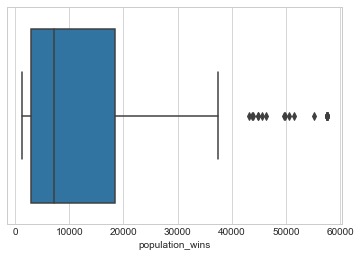

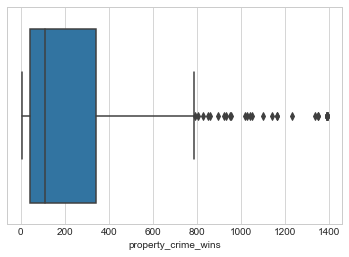

In [9]:
continuous_variables = ['population_wins', 'property_crime_wins']

for var in continuous_variables:
    sns.boxplot(crime[var])
    plt.show()

This looks much, much better to me.

### Recoding to specification

$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$


In [10]:
# Create a function that will transform murder and robbery from continuous to categorical variables.

def cont_to_cat(x):
    if x > 0:
        return 1
    else:
        return 0

In [11]:
# Population^2
crime['population_sq'] = crime['population_wins'] ** 2

# Murder
crime['murder_cat'] = crime['murder_and_nonnegligent_manslaughter'].apply(cont_to_cat)

# Robbery
crime['robbery_cat'] = crime['robbery'].apply(cont_to_cat)

In [12]:
crime_clean = crime[['population_wins', 'population_sq', 'murder_cat', 'robbery_cat', 'property_crime']]

In [13]:
crime_clean.head()

,population_wins,population_sq,murder_cat,robbery_cat,property_crime
city,,,,,
Adams Village,1861.0,3.463321e+06,0,0,12.0
Addison Town and Village,2577.0,6.640929e+06,0,0,24.0
Akron Village,2846.0,8.099716e+06,0,0,16.0
Albany,57559.0,3.313038e+09,1,1,4090.0
Albion Village,6388.0,4.080654e+07,0,1,223.0
